# Conservation analysis

This Jupyter notebook presents a **conservation analysis** of the ADP-ribose binding site in ADRP domain from SARS-CoV-2 (PDB ID: 6WEN, chain A), SARS-CoV (PDB ID: 2ACF, chain B), MERS-CoV (PDB ID: 5HIH, chain A), NL63 (PDB ID: 2VRI, chain A), HCoV-229E (PDB ID: 3EJG, chain A), FCoV (PDB ID: 3ETI, chain B) and macrodomains macroD1 (PDB ID: 2X47, chain A) and macroD2 (PDB ID: 6Y73, chain D) from human. These protein domains were selected using Dali and selecting homologs in an apo form. The structures were re-aligned using MUSTANG algorithm from YASARA program. 

Here, we show cavity detection and characterization on ADRP domain from SARS-CoV-2 (PDB ID: 6WEN, chain A), our reference. Further, we performed the conservation of cavity points, that were detected in at least two structures, the hydropathy profile of the cavities, and the hierarchical clustering dendrogram of the frequency of residues surrounding the compared cavities.

# Requirements

In [1]:
# Import required modules
import os
import toml
import zipfile
import numpy
import pyKVFinder
import nglview
import IPython
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# Unzip required files
if not os.path.isdir('./data'):
    with zipfile.ZipFile('./data.zip', 'r') as zipped:
        zipped.extractall('./data')

In [3]:
# Get DALI proteins
pdbs = [f for f in sorted(os.listdir('./data')) if f.endswith('.pdb')]
print(pdbs)

# Get reference protein
reference = './data/6WEN-A.pdb'

['2ACF-B.pdb', '2VRI-A.pdb', '2X47-A.pdb', '3EJG-A.pdb', '3ETI-B.pdb', '5HIH-A.pdb', '6WEN-A.pdb', '6Y73-D.pdb']


In [4]:
# Define a common custom box using parKVFinder PyMOL plugin
box = {
    'box': {
        'p1': [ 3.53, -0.87, 9.21,],
        'p2': [ 17.33, -0.87, 9.21,],
        'p3': [ 3.53, 14.73, 9.21,],
        'p4': [ 3.53, -0.87, 28.72,],
    }
}

# Write common custom box to file
with open('box.toml', 'w') as f:
    toml.dump(box, f)

In [5]:
# Display custom box with reference

# Convert list to numpy.array
p1 = numpy.array(box['box']['p1'])
p2 = numpy.array(box['box']['p2'])
p3 = numpy.array(box['box']['p3'])
p4 = numpy.array(box['box']['p4'])

# Get x, y, z axes lengths
norm_x = numpy.linalg.norm(numpy.array(p2) - numpy.array(p1))
norm_y = numpy.linalg.norm(numpy.array(p3) - numpy.array(p1))
norm_z = numpy.linalg.norm(numpy.array(p4) - numpy.array(p1))

# Function to get axes coordinates
def get(point, origin, length):
    sina = (point[1] - origin[1]) / numpy.sqrt( ((point[0]-origin[0])**2) + ((point[1]-origin[1])**2) + 0.0001)
    cosa = (point[0] - origin[0]) / numpy.sqrt( ((point[0]-origin[0])**2) + ((point[1]-origin[1])**2) + 0.0001)
    sinb = (point[2] - origin[2]) / length
    cosb = numpy.sqrt( ((point[0]-origin[0])**2) + ((point[1]-origin[1])**2) ) / length
    return numpy.array([cosb*cosa*length, cosb*sina*length, sinb*length])

# Get axes coordinates
dx = get(p2, p1, norm_x)
dy = get(p3, p1, norm_y)
dz = get(p4, p1, norm_z)

# Create NGL Viewer widget
view = nglview.NGLWidget()

# Add protein
ref = view.add_component(reference)
ref.clear()
ref.add_cartoon(color='grey')

# Add custom box
view.shape.add_cylinder(list(p1), list(p2), [ 1, 0, 0 ], 0.1 , 'x')
view.shape.add_cylinder(list(p1), list(p3), [ 0, 1, 0 ], 0.1 , 'y')
view.shape.add_cylinder(list(p1), list(p4), [ 0, 0, 1 ], 0.1 , 'z')
view.shape.add_cylinder(list(p2), list(p2+dy), [ 0, 0, 0 ], 0.1, '0')
view.shape.add_cylinder(list(p2), list(p2+dz), [ 0, 0, 0 ], 0.1, '1')
view.shape.add_cylinder(list(p3), list(p3+dx), [ 0, 0, 0 ], 0.1, '2')
view.shape.add_cylinder(list(p3), list(p3+dz), [ 0, 0, 0 ], 0.1, '3')
view.shape.add_cylinder(list(p4), list(p4+dx), [ 0, 0, 0 ], 0.1, '4')
view.shape.add_cylinder(list(p4), list(p4+dy), [ 0, 0, 0 ], 0.1, '5')
view.shape.add_cylinder(list(p2+dy), list(p2+dy+dz), [ 0, 0, 0 ], 0.1, '6')
view.shape.add_cylinder(list(p2+dz), list(p2+dy+dz), [ 0, 0, 0 ], 0.1, '7')
view.shape.add_cylinder(list(p3+dz), list(p2+dy+dz), [ 0, 0, 0 ], 0.1, '8')

view

NGLWidget()

# Cavity detection and characterization on reference

In [6]:
# Detect and characterize cavities on reference
results = pyKVFinder.run_workflow(reference, probe_out=12.0, volume_cutoff=100.0, box='./box.toml', ignore_backbone=True, include_depth=True, include_hydropathy=True)

# Export cavities and results
results.export_all(fn='./results/6WEN/6WEN.results.toml', output='./results/6WEN/6WEN.output.pdb', output_hydropathy='./results/6WEN/6WEN.EisenbergWeiss.pdb', include_frequencies_pdf=True, pdf='./results/6WEN/6WEN.barplots.pdf')

In [7]:
# Visualize interface residues (red licorice)

# Define the tag of the cavity you want to see 
tag = 'KAA'

# Create NGL Viewer widget
view = nglview.NGLWidget()

# Add protein
p1 = view.add_component(reference)
p1.clear()
p1.add_cartoon(color='grey')

# Select interface residues
selection = f"{' or '.join([f'({sel[0]} and :{sel[1]})' for sel in results.residues[tag]])}"

# Add interface residues
p1.add_licorice(color='red', selection=selection)

# Add cavities
p2 = view.add_component('./results/6WEN/6WEN.output.pdb')
p2.clear()
p2.add_surface(color='white', opacity=0.5, surfaceType='vws', probeRadius=0.3)

# Show
view

NGLWidget()

In [8]:
# Visualize depth of cavity points (rainbow scale)

# Create NGL Viewer widget
view = nglview.NGLWidget()

# Add protein
p1 = view.add_component(reference)
p1.clear()
p1.add_cartoon(color='grey')

# Add depth cavities
p3 = view.add_component('./results/6WEN/6WEN.output.pdb')
p3.clear()
p3.add_surface(colorScheme='bfactor', colorScale='rainbow', colorReverse=True, surfaceType='vws', probeRadius=0.3)

# Show
view

NGLWidget()

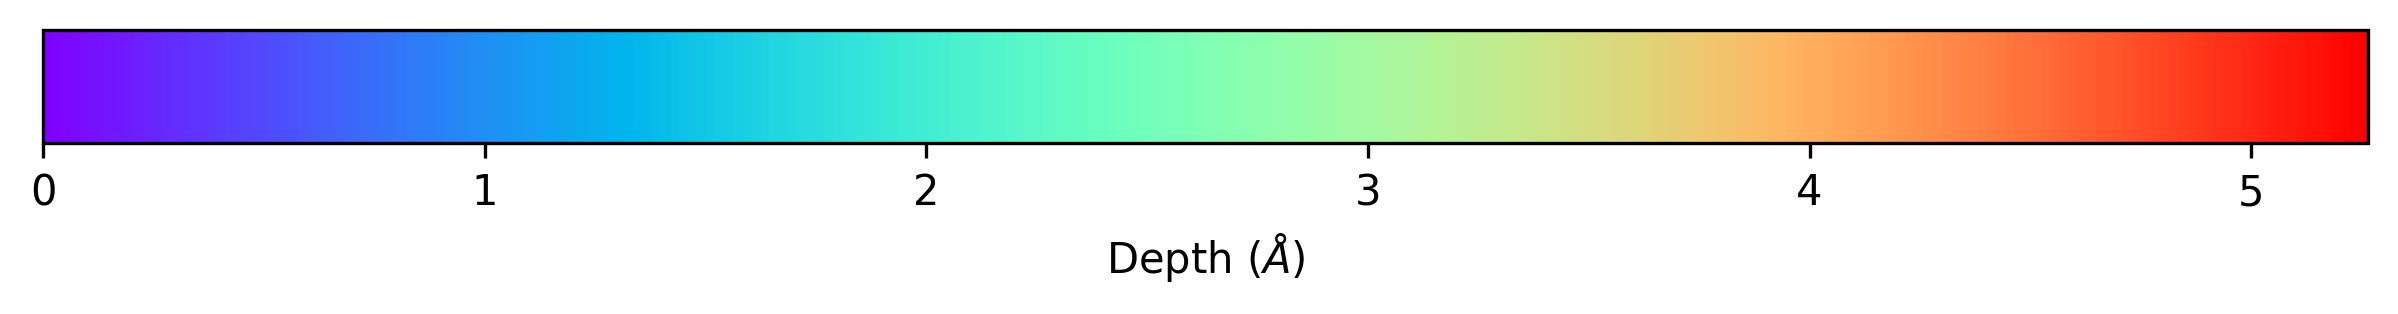

In [9]:
# Plot depth scale
fig, ax = plt.subplots(figsize=(10, 0.5), dpi=300)
norm = mpl.colors.Normalize(vmin=results.depths.min(), vmax=results.depths.max())
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=plt.get_cmap('rainbow'), norm=norm, orientation='horizontal')
cb1.set_label(r'Depth ($\AA$)')


In [10]:
# Visualize hydropathy of cavity points (yellow-white-blue scale)

# Create NGL Viewer widget
view = nglview.NGLWidget()

# Add protein
p1 = view.add_component(reference)
p1.clear()
p1.add_cartoon(color='grey')

# Add hydrophobicity scale cavities
p4 = view.add_component('./results/6WEN/6WEN.EisenbergWeiss.pdb')
p4.clear()
p4.add_surface(colorScheme='bfactor', colorMode='rgb', colorScale=[0xFFFF00, 0xffffff, 0x0000FF], surfaceType='vws', probeRadius=0.3)

# Show
view

NGLWidget()

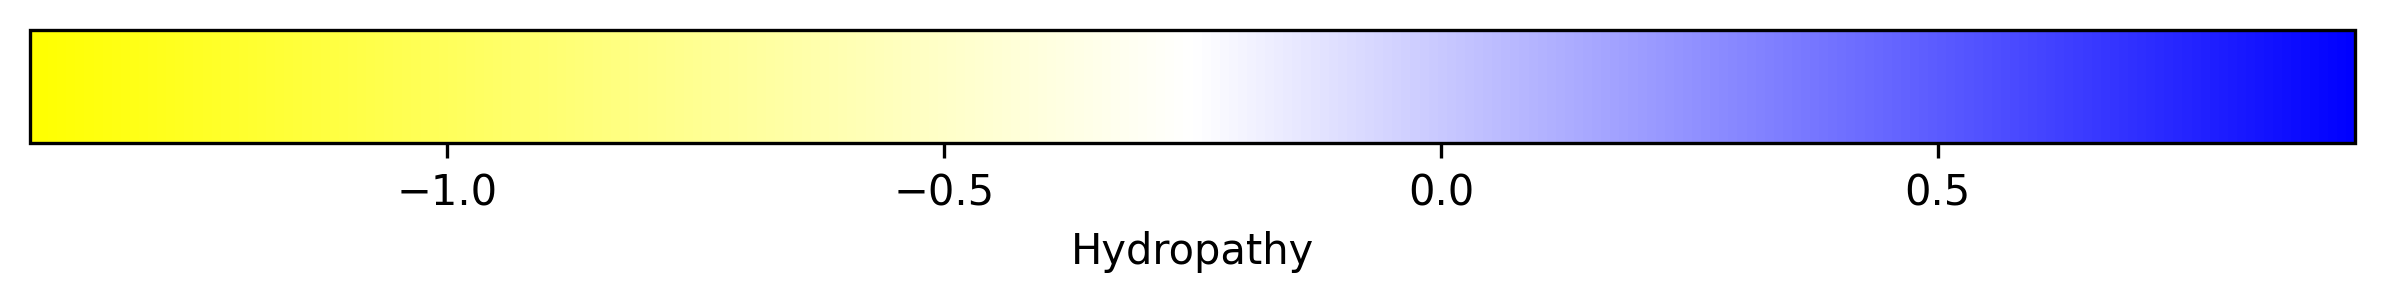

In [11]:
# Plot hydropathy scale
fig, ax = plt.subplots(figsize=(10, 0.5), dpi=300)
norm = mpl.colors.Normalize(vmin=results.scales.min(), vmax=results.scales.max())
cm = mpl.colors.LinearSegmentedColormap.from_list('hydropathy', colors=["#FFFF00", "#ffffff", "#0000FF"])
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cm, norm=norm, orientation='horizontal')
cb1.set_label('Hydropathy')

In [12]:
# Display bar charts of residues
IPython.display.IFrame("./results/6WEN/6WEN.barplots.pdf", width=600, height=300)

# Conservation analysis

In [13]:
# Create empty array
occurrence = None

for pdb in pdbs:
    # Load atomic data
    atomic = pyKVFinder.read_pdb(os.path.join('./data', pdb))
    
    # Get vertices from file
    vertices, atomic = pyKVFinder.get_vertices_from_file('./box.toml', atomic, probe_out=12.0)
    
    # Detect biomolecular cavities
    ncav, cavities = pyKVFinder.detect(atomic, vertices, probe_out=12.0, volume_cutoff=100.0, box_adjustment=True)
    
    if occurrence is None:
        occurrence = (cavities > 1).astype(int)
    else:
        occurrence += (cavities > 1).astype(int)

# Get cavity points
noise_cutoff = 2
cavities = 2 * ((occurrence >= noise_cutoff).astype('int32'))

# Export cavities with percentage of occurrence in B-factor column
pyKVFinder.export('./results/conservation.pdb', cavities, None, vertices, B=occurrence) 

In [14]:
# Visualize the occurrence of cavity points throughout the simulation

# Create NGL Viewer widget
view = nglview.NGLWidget()

# Disply referece 6W02 as grey cartoon
pdb = view.add_component(reference)
pdb.clear()
pdb.add_cartoon(color='grey', opacity=0.5)

# Display surface points colored by hydrophobicity
cavs = view.add_component('./results/conservation.pdb')
cavs.clear()
cavs.add_point(colorScheme='bfactor', colorScale='rainbow', colorReverse=True)

# Display on NGL viewer
view

NGLWidget()

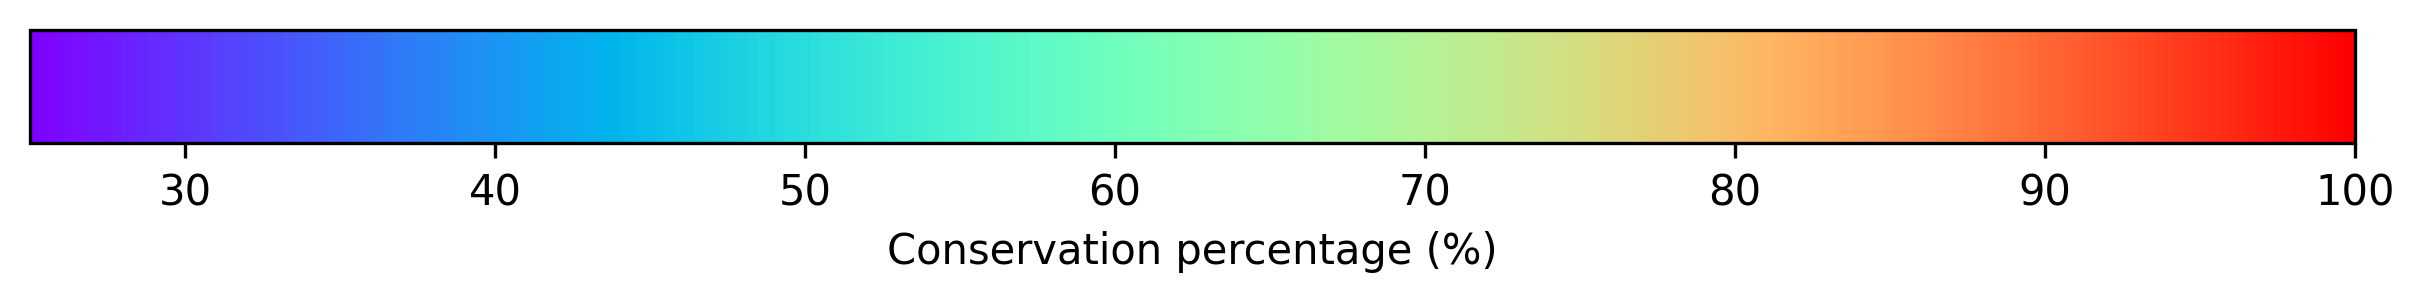

In [15]:
# Plot conservation pervcentage scale
fig, ax = plt.subplots(figsize=(10, 0.5), dpi=300)
norm = mpl.colors.Normalize(vmin=noise_cutoff / len(pdbs) * 100, vmax=occurrence.max() / len(pdbs) * 100)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=plt.get_cmap('rainbow'), norm=norm, orientation='horizontal')
cb1.set_label(r'Conservation percentage (%)')

# Hydropathy analysis

In [16]:
# hydropathy
hydropathy = {}
frequency = {}

for pdb in pdbs:
    # Load atomic coordinates and information
    atomic = pyKVFinder.read_pdb(os.path.join('./data', pdb))
    
    # Get vertices from file
    vertices, atomic = pyKVFinder.get_vertices_from_file('./box.toml', atomic, probe_out=12.0)
    
    # Detect biomolecular cavities
    ncav, cavities = pyKVFinder.detect(atomic, vertices, probe_out=12.0, volume_cutoff=100.0, box_adjustment=True)

    # Constitutional characterization
    residues = pyKVFinder.constitutional(cavities, atomic, vertices, ignore_backbone=True)
    frequencies = pyKVFinder.calculate_frequencies(residues)
    
    # Accumulate frequency
    frequency[f"{pdb.replace('.pdb', '')}"] = frequencies['KAA']['RESIDUES']
    
    # Depth characterization
    depths, max_depth, avg_depth = pyKVFinder.depth(cavities)
    
    # Spatial characterization
    surface, volume, area = pyKVFinder.spatial(cavities)
    
    # Hydropathy characterization
    scales, avg_hydropathy = pyKVFinder.hydropathy(surface, atomic, vertices, ignore_backbone=True)
    
    # Accumulate hydropathy arrays
    hydropathy[f"{pdb.replace('.pdb', '')}"] = scales.reshape(-1)
    
    # Export cavities
    output_cavity = f"./results/detections/{pdb.replace('.pdb', '')}.cavities.pdb"
    output_hydropathy = f"./results/detections/{pdb.replace('.pdb', '')}.EisenbergWeiss.pdb"
    pyKVFinder.export(output_cavity, cavities, surface, vertices, output_hydropathy=output_hydropathy, scales=scales)
    
    # Write results
    output_results = f"./results/detections/{pdb.replace('.pdb', '')}.results.toml"
    pyKVFinder.write_results(output_results, input=pdb, ligand=None, output=output_cavity, output_hydropathy=output_hydropathy, volume=volume, area=area, max_depth=max_depth, avg_depth=avg_depth, avg_hydropathy=avg_hydropathy, residues=residues, frequencies=frequencies)

## Data analysis

In [17]:
# Import required packages
import scipy
from scipy.cluster.hierarchy import dendrogram, linkage
import pandas as pd

In [18]:
# Dictionary
names = {
    '2ACF-B': 'SARS-CoV', 
    '2VRI-A': 'NL63',
    '2X47-A': 'human macroD1', 
    '3EJG-A': 'HCoV-299E', 
    '3ETI-B': 'FCoV', 
    '5HIH-A': 'MERS-CoV', 
    '6WEN-A': 'SARS-CoV-2', 
    '6Y73-D': 'human macroD2',
}

## Hydropathy distributions

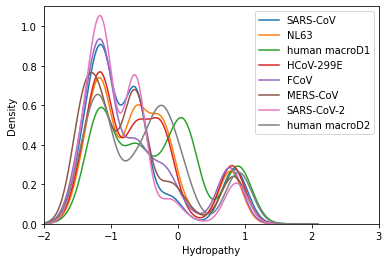

In [19]:
# KDE distributions

# Prepare data
data = pd.DataFrame(hydropathy).replace(0.0, numpy.nan)

# Rename columns
data.columns = list(names.values())

# Plot KDE distributions
ax = data.plot.kde()
ax.set_xlim(-2, 3)
ax.set_ylim(0, 1.1)
ax.set_xlabel('Hydropathy')

# Save to file
fig = ax.get_figure()
os.mkdir('./results/plots') if not os.path.exists('./results/plots') else None
fig.savefig('./results/plots/kde.png', dpi=300)

## Hierarchical clustering

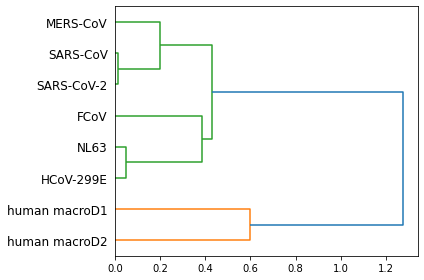

In [20]:
# Hierarchical clustering of residues frequency

# Prepare data
data = pd.DataFrame.from_dict(frequency, orient='index').replace(numpy.nan, 0.0)

# Rename index
data.index = list(names.values())

# Calculate distances
linked = linkage(data, method='complete', metric='correlation')

# Create dendogram
scipy.cluster.hierarchy.dendrogram(linked, orientation='right', labels=data.index, distance_sort='descending', show_leaf_counts=True)

# Save to file
plt.tight_layout()
plt.savefig('./results/plots/dendogram.png', dpi=300)